# Task 1: Data Preparation and Balancing


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1.1 Download and Load the Dataset

In [ ]:
# Load the labeled dataset from github
url = "https://raw.githubusercontent.com/imberator/CENG463_HW2/refs/heads/main/format_dataset.csv"
chat_doctor_df = pd.read_csv(url)
chat_doctor_df.head()

,idx,disease,Symptom,reason,TestsAndProcedures,commonMedications,label
0,0,Panic disorder,"['Anxiety and nervousness', 'Depression', 'Sho...",Panic disorder is an anxiety disorder characte...,"['Psychotherapy', 'Mental health counseling', ...","['Lorazepam', 'Alprazolam (Xanax)', 'Clonazepa...",disease
1,1,Vocal cord polyp,"['Hoarse voice', 'Sore throat', 'Difficulty sp...","beclomethasone nasal product,","['Tracheoscopy and laryngoscopy with biopsy', ...","['Esomeprazole (Nexium)', 'Beclomethasone Nasa...",medication
2,2,Turner syndrome,"['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...",Turner syndrome or Ullrich\xe2\x80\x93Turner s...,"['Complete physical skin exam performed (ML)',...","['Somatropin', 'Sulfamethoxazole (Bactrim)', '...",disease
3,3,Cryptorchidism,"['Symptoms of the scrotum and testes', 'Swelli...",Cryptorchidism (derived from the Greek \xce\xb...,"['Complete physical skin exam performed (ML)',...","['Haemophilus B Conjugate Vaccine (Obsolete)',...",disease
4,4,Poisoning due to ethylene glycol,"['Abusing alcohol', 'Fainting', 'Hostile behav...","thiamine,","['Intravenous fluid replacement', 'Hematologic...","['Lorazepam', 'Thiamine', 'Naloxone (Suboxone)...",medication


In [ ]:
# Null values are checked. None found. No need for removal of rows or filling missing values.
print(chat_doctor_df.isnull().sum())

idx                   0
disease               0
Symptom               0
reason                0
TestsAndProcedures    0
commonMedications     0
label                 0
dtype: int64


In [ ]:
# Duplicate values are checked. None found. No need for correction or removal.
print(chat_doctor_df.duplicated().sum())

0


### 1.2 Extract and Balance Classes

In [ ]:
# The count of each label
num_labels = chat_doctor_df.iloc[:, 6].value_counts()
print(num_labels)

label
disease       439
medication    148
symptom       144
test           65
Name: count, dtype: int64


In [ ]:
# Extracting the label which has the minimum number of counts
min_label_count = num_labels.min()
min_label_name = num_labels[num_labels == min_label_count].index[0]
min_label_name, min_label_count

('test', 65)

In [ ]:
remaining_labels = chat_doctor_df[chat_doctor_df["label"] != min_label_name]["label"].unique()

dataset = pd.DataFrame(chat_doctor_df[chat_doctor_df["label"] == min_label_name].copy(deep=True))
n = len(remaining_labels)
for i in range(n):
    label = remaining_labels[i]
    label_df = chat_doctor_df[chat_doctor_df["label"] == label].copy(deep=True)
    # Completely balanced dataset yielded poor results, thus we decided to increase the number of samples
    # of remaining labels. This increased model performances, especially random forest.
    label_df = label_df.sample(100)
    dataset = pd.concat([dataset, label_df], ignore_index=True)

dataset.shape

(365, 7)

In [ ]:
value_counts = dataset['label'].value_counts().to_frame()
value_counts

,count
label,
disease,100
medication,100
symptom,100
test,65


# Task 2: Model Implementation and Evaluation

### 2.0 Data Preparation

In [ ]:
import re

reasons = dataset.iloc[:, 3].values
labels = dataset.iloc[:, 6].values

processed_features = []

for sentence in range(0, len(reasons)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(reasons[sentence]))

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [ ]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.1 Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
precision = precision_score(y_test, svm_classifier.predict(X_test_scaled), average='weighted')
recall = recall_score(      y_test, svm_classifier.predict(X_test_scaled), average='weighted')
f1 = f1_score(              y_test, svm_classifier.predict(X_test_scaled), average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.6455930064888248
Recall: 0.6301369863013698
F1 Score: 0.627567257704244


Precision and Recall values are close to each other, indicating that the model does not significantly favor precision over recall. SVM can be a good fit for text classification tasks due to their robustness to high dimensional data (such as text) because they depend on a subset of data points (support vectors), not the dimensionality. While text classification tasks are often linearly separable (appropriate for SVMs), these results may indicate that this dataset involve non-linear relationships. Therefore, SVM is not appropriate for this dataset.

### 2.2 Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_scaled, y_train)

GaussianNB()

In [ ]:
precision = precision_score(y_test, gnb_classifier.predict(X_test_scaled), average='weighted')
recall = recall_score(      y_test, gnb_classifier.predict(X_test_scaled), average='weighted')
f1 = f1_score(              y_test, gnb_classifier.predict(X_test_scaled), average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.5575342465753425
Recall: 0.547945205479452
F1 Score: 0.5521602505793689


GaussianNB assumes that the features follow a normal distribution and works best with continuous data. However, text data typically doesn't follow these patterns. We can see the implications on the results of the evaluation metrics.

Due to these problems with the GaussianNB we tried to use MultinomialNB, but it did not perform any better than GaussianNB (in fact, it yielded worse results). The results of MultinomialNB model are shown below. Since BernoulliNB expects binary labels, we did not use it.

We already know that GaussianNB is not appropriate for text classification tasks and the results, low metric scores, support this claim.

Although MultinomialNB is suitable for text classification, this dataset may not be appropriate for MultinomialNB due to  following reasons:
    - The dataset is relatively small.
    - The dataset may involve nonlinear relationships.
    

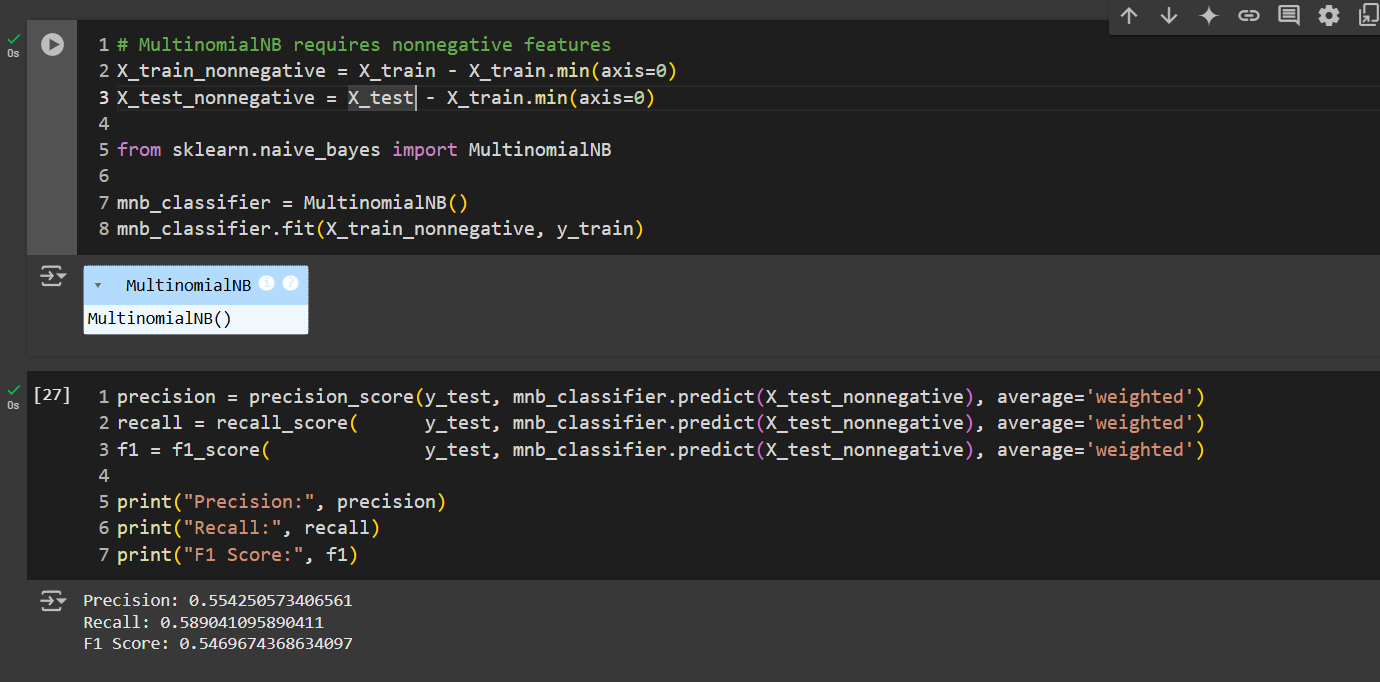

### 2.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
precision = precision_score(y_test, rf_classifier.predict(X_test_scaled), average='weighted')
recall = recall_score(      y_test, rf_classifier.predict(X_test_scaled), average='weighted')
f1 = f1_score(              y_test, rf_classifier.predict(X_test_scaled), average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.5920061673486331
Recall: 0.5616438356164384
F1 Score: 0.5250884458677755


Random Forests can be prone to overfitting, especially when dealing with high-dimensional and sparse data such as text features. However, their ensemble nature helps mitigate this to some extent.

Random Forests are robust to noise and handle non-linear decision boundaries effectively. They also address the overfitting issues commonly associated with decision trees by averaging multiple trees' predictions.

Random Forests rely on splitting data into meaningful groups based on key features. In sparse data, the useful information may be spread thinly across many features, making it challenging to find effective splits.
Moreover, when most feature values are zeros (common in sparse data), decision trees within the forest can become unstable, leading to suboptimal performance.

At first we used completely balanced dataset but in this case we realized random forest doesn't predict any 'test' values. For this reason we modified the dataset to be less balanced. This adjustment allowed the model to make predictions for the 'test' class effectively.




# Task 3: Model Comparison and Justification

### 3.1 Visualize Model Results

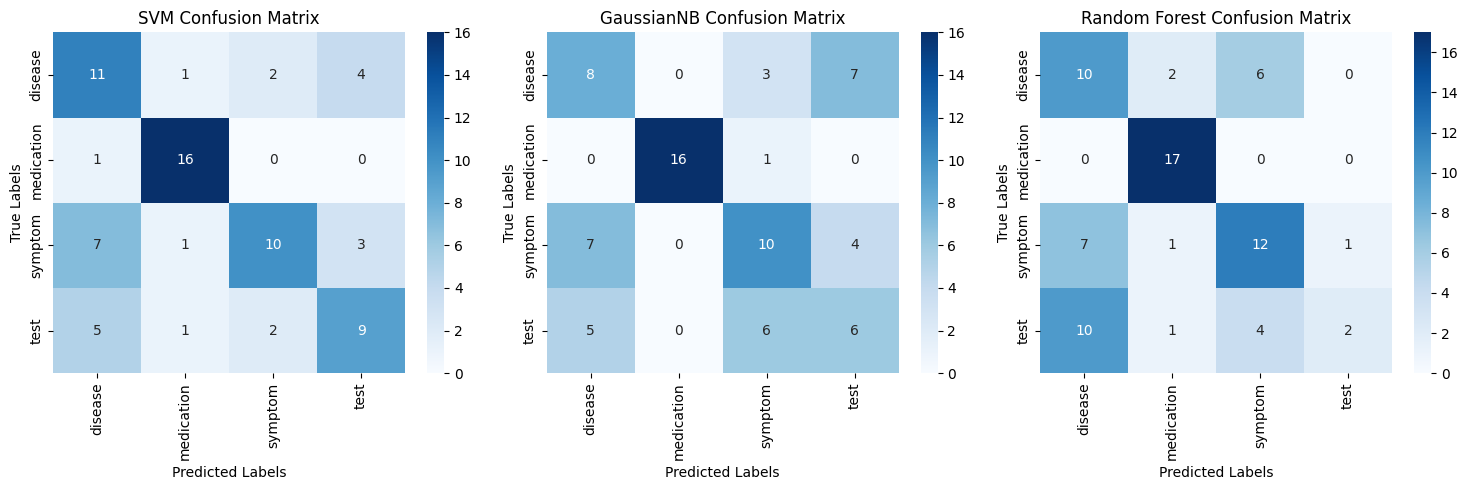

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_svm = confusion_matrix(y_test, svm_classifier.predict(X_test_scaled))
cm_gnb = confusion_matrix(y_test, gnb_classifier.predict(X_test_scaled))
cm_rf = confusion_matrix(y_test, rf_classifier.predict(X_test_scaled))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_, ax=ax[0])
ax[0].set_title("SVM Confusion Matrix")
ax[0].set_xlabel("Predicted Labels")
ax[0].set_ylabel("True Labels")

sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues',
            xticklabels=gnb_classifier.classes_, yticklabels=gnb_classifier.classes_, ax=ax[1])
ax[1].set_title("GaussianNB Confusion Matrix")
ax[1].set_xlabel("Predicted Labels")
ax[1].set_ylabel("True Labels")

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_, ax=ax[2])
ax[2].set_title("Random Forest Confusion Matrix")
ax[2].set_xlabel("Predicted Labels")
ax[2].set_ylabel("True Labels")

plt.tight_layout()
plt.show()

### 3.2 Model Performance Comparison

Common Issues Across All Models:

All models face significant difficulty in predicting the "test" label. This issue is especially pronounced in the Random Forest model.
Conversely, all models perform exceptionally well in predicting the "medication" label, indicating a clear and distinguishable feature set for this class.

SVM Model:

The SVM model handles separable classes effectively, as demonstrated by its high accuracy in predicting the "medication" label.
However, it struggles with overlapping or complex class boundaries, such as distinguishing "test" from "disease". A notable pattern is the frequent misclassification of "disease" samples as "test".

GaussianNB Model:

Gaussian Naive Bayes struggles due to the dataset's feature distribution likely not aligning well with the Gaussian assumption.
The poor performance can also be attributed to challenges in handling sparse or high-dimensional data effectively.

Random Forest Model:

Although Random Forest performs robustly overall, just like SVM, it misclassifies "disease" samples as "test" quite often, highlighting an area for improvement.
This model's difficulty in distinguishing certain classes, despite its strong performance in others, suggests room for optimization in feature importance or parameter tuning.